In [2]:
import os
import glob
import gc
import requests
import zipfile
import io
import pandas as pd
import polars as pl
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import shutil
import branca.colormap as cm 
import numpy as np

CONFIG = {
    "DATA_FOLDER": "nyc_data",
    "OUTPUT_CSV": "eda_data",
    "OUTPUT_MAPS": "maps",
    "TEMP_FOLDER": "temp_chunks",
    "SHP_FILENAME": "nyc_data/taxi_zones.zip",
    "YEAR_RANGE": (2016, 2025)
}

In [100]:
class TaxiGeoPipeline:
    def __init__(self, config):
        self.config = config
        self.gdf = None
        self.data_monthly = None
        self.data_hourly = None

    # 1. GEOSPATIAL PREPARATION
    def load_shapefile(self):
        # Load and Transform
        self.gdf = gpd.read_file(self.config["SHP_FILENAME"])
        self.gdf = self.gdf.to_crs("EPSG:4326")
        self.gdf['LocationID'] = self.gdf['LocationID'].astype(int)
        self.gdf = self.gdf.set_index('LocationID')
        print(f">>> [Geo] Loaded {len(self.gdf)} taxi zones.")

    # 2. DATA PROCESSING (POLARS)
    def process_data(self):
        """
        Scans parquets. 
        Checks cache to skip existing chunks.
        Forces Int64 types to prevent SchemaError during merge.
        """
        all_files = sorted(glob.glob(os.path.join(self.config["DATA_FOLDER"], "**/*.parquet")))
        print(f">>> [Data] Found {len(all_files)} raw files.")
        
        if not all_files:
            raise FileNotFoundError("No parquet files found.")

        files_processed_count = 0

        for i, file_path in enumerate(all_files):
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            
            # Define Expected Temp Paths
            temp_pu_m_path = os.path.join(self.config['TEMP_FOLDER'], f"pu_monthly_{base_name}.parquet")
            temp_do_m_path = os.path.join(self.config['TEMP_FOLDER'], f"do_monthly_{base_name}.parquet")
            temp_pu_h_path = os.path.join(self.config['TEMP_FOLDER'], f"pu_hourly_{base_name}.parquet")
            temp_do_h_path = os.path.join(self.config['TEMP_FOLDER'], f"do_hourly_{base_name}.parquet")

            # Check Cache
            if (os.path.exists(temp_pu_m_path) and os.path.exists(temp_do_m_path) and 
                os.path.exists(temp_pu_h_path) and os.path.exists(temp_do_h_path)):
                continue

            try:
                print(f"    Processing {base_name}...")
                q = pl.scan_parquet(file_path)
                
                # Standardize columns
                schema_map = {}
                for c in q.columns:
                    if c.lower() == 'tpep_pickup_datetime': schema_map[c] = 'tpep_pickup_datetime'
                    if c.lower() == 'tpep_dropoff_datetime': schema_map[c] = 'tpep_dropoff_datetime'
                    if c.lower() == 'pulocationid': schema_map[c] = 'PULocationID'
                    if c.lower() == 'dolocationid': schema_map[c] = 'DOLocationID'
                    if c.lower() == 'total_amount': schema_map[c] = 'total_amount'
                    if c.lower() == 'fare_amount': schema_map[c] = 'fare_amount'
                    if c.lower() == 'tip_amount': schema_map[c] = 'tip_amount'
                
                if schema_map: q = q.rename(schema_map)

                # Filter Years
                q = q.with_columns([
                    pl.col("tpep_pickup_datetime").dt.year().alias("year"),
                    pl.col("tpep_pickup_datetime").dt.month().alias("month"),
                    pl.col("tpep_pickup_datetime").dt.hour().alias("hour")
                ]).filter(
                    (pl.col("year") >= self.config["YEAR_RANGE"][0]) & 
                    (pl.col("year") <= self.config["YEAR_RANGE"][1])
                )

                # --- Monthly Aggregation ---
                pu_monthly = q.group_by(["year", "month", "PULocationID"]).agg([
                    pl.len().alias("pu_count"),
                    pl.col("total_amount").sum().alias("total_rev"),
                    pl.col("fare_amount").sum().alias("sum_fare"),
                    pl.col("tip_amount").sum().alias("sum_tip")
                ]).collect()

                do_monthly = q.group_by(["year", "month", "DOLocationID"]).agg([
                    pl.len().alias("do_count")
                ]).collect()

                # *** CRITICAL FIX: Force IDs to Int64 ***
                pu_monthly = pu_monthly.with_columns(pl.col("PULocationID").cast(pl.Int64))
                do_monthly = do_monthly.with_columns(pl.col("DOLocationID").cast(pl.Int64))

                pu_monthly.write_parquet(temp_pu_m_path)
                do_monthly.write_parquet(temp_do_m_path)

                # --- Hourly Aggregation ---
                pu_hourly = q.group_by(["hour", "PULocationID"]).agg(pl.len().alias("pu_count")).collect()
                do_hourly = q.group_by(["hour", "DOLocationID"]).agg(pl.len().alias("do_count")).collect()
                
                # *** CRITICAL FIX: Force IDs to Int64 ***
                pu_hourly = pu_hourly.with_columns(pl.col("PULocationID").cast(pl.Int64))
                do_hourly = do_hourly.with_columns(pl.col("DOLocationID").cast(pl.Int64))

                pu_hourly.write_parquet(temp_pu_h_path)
                do_hourly.write_parquet(temp_do_h_path)

                files_processed_count += 1
                
                del pu_monthly, do_monthly, pu_hourly, do_hourly, q
                if files_processed_count % 5 == 0:
                    gc.collect()

            except Exception as e:
                print(f"Error processing {base_name}: {e}")

        print(">>> [Data] All files scanned. Merging from cache...")
        self._merge_monthly_data()
        self._merge_hourly_data()

    def _merge_monthly_data(self):
        pu_pattern = os.path.join(self.config['TEMP_FOLDER'], "pu_monthly_*.parquet")
        do_pattern = os.path.join(self.config['TEMP_FOLDER'], "do_monthly_*.parquet")

        if not glob.glob(pu_pattern):
            print("No cached data found to merge.")
            return

        print("    Merging Monthly Data...")
        
        # This tells Polars: "If you see Int32 and Int64 mixed, convert all to Int64"
        try:
            scan_opts = pl.ScanCastOptions(integer_cast="upcast")
        except AttributeError:
            # Fallback for older Polars versions
            scan_opts = None

        pu_lazy = pl.scan_parquet(pu_pattern, cast_options=scan_opts)
        do_lazy = pl.scan_parquet(do_pattern, cast_options=scan_opts)

        # Global Reduce
        df_pu = pu_lazy.group_by(["year", "month", "PULocationID"]).agg([
            pl.col("pu_count").sum(),
            pl.col("total_rev").sum(),
            pl.col("sum_fare").sum(),
            pl.col("sum_tip").sum()
        ]).collect()

        df_pu = df_pu.with_columns([
            (pl.col("sum_fare") / pl.col("pu_count")).alias("avg_fare"),
            (pl.col("sum_tip") / pl.col("pu_count")).alias("avg_tip")
        ])

        df_do = do_lazy.group_by(["year", "month", "DOLocationID"]).agg([
            pl.col("do_count").sum()
        ]).collect()

        df_pu = df_pu.rename({"PULocationID": "LocationID"})
        df_do = df_do.rename({"DOLocationID": "LocationID"})

        # Final join
        final = df_pu.join(df_do, on=["year", "month", "LocationID"], how="outer")
        final = final.filter(
            (pl.col("year").is_not_null()) & 
            (pl.col("month").is_not_null()) & 
            (pl.col("year") > 0) & 
            (pl.col("month") > 0)
        ).fill_null(0)

        final = final.with_columns([
            pl.col("pu_count").cast(pl.Int64),
            pl.col("do_count").cast(pl.Int64)
        ])

        final = final.with_columns([
            (pl.col("pu_count") - pl.col("do_count")).alias("net_traffic"),
            pl.datetime(pl.col("year"), pl.col("month"), 1).dt.timestamp("ms").cast(pl.Int64).alias("ts_sec")
        ])
        
        self.data_monthly = final.to_pandas()
        self.data_monthly.to_csv(f"{self.config['OUTPUT_CSV']}/geo_monthly_stats.csv", index=False)

    def _merge_hourly_data(self):
        pu_pattern = os.path.join(self.config['TEMP_FOLDER'], "pu_hourly_*.parquet")
        do_pattern = os.path.join(self.config['TEMP_FOLDER'], "do_hourly_*.parquet")

        if not glob.glob(pu_pattern):
            return

        print("    Merging Hourly Data...")
        
        # *** FIX: Same fix for hourly data ***
        try:
            scan_opts = pl.ScanCastOptions(integer_cast="upcast")
        except AttributeError:
            scan_opts = None

        pu_lazy = pl.scan_parquet(pu_pattern, cast_options=scan_opts)
        do_lazy = pl.scan_parquet(do_pattern, cast_options=scan_opts)

        df_pu = pu_lazy.group_by(["hour", "PULocationID"]).agg(pl.col("pu_count").sum()).collect()
        df_do = do_lazy.group_by(["hour", "DOLocationID"]).agg(pl.col("do_count").sum()).collect()

        df_pu = df_pu.rename({"PULocationID": "LocationID"})
        df_do = df_do.rename({"DOLocationID": "LocationID"})

        final = df_pu.join(df_do, on=["hour", "LocationID"], how="outer").fill_null(0)
        
        final = final.filter(pl.col("hour").is_not_null())
        final = final.fill_null(0)

        final = final.with_columns([
            pl.col("pu_count").cast(pl.Int64),
            pl.col("do_count").cast(pl.Int64)
        ])
        
        final = final.with_columns([
            (pl.col("pu_count") - pl.col("do_count")).alias("net_traffic"),
            (pl.datetime(2025, 1, 1, pl.col("hour"), 0, 0).dt.timestamp("ms").cast(pl.Int64)).alias("ts_sec")
        ])

        self.data_hourly = final.to_pandas()
        self.data_hourly.to_csv(f"{self.config['OUTPUT_CSV']}/geo_hourly_stats.csv", index=False)

    def force_clear_cache(self):
        """Call this manually if you want to restart from scratch"""
        if os.path.exists(self.config["TEMP_FOLDER"]):
            shutil.rmtree(self.config["TEMP_FOLDER"])
            os.makedirs(self.config["TEMP_FOLDER"])
            print("Cache cleared.")

    def generate_heatmap(self, data_type="monthly", metric="net_traffic", title="Map"):
        import numpy as np
        
        print(f">>> [Map] Generating {title} ({metric})...")
        df = self.data_monthly if data_type == "monthly" else self.data_hourly
        
        if df is None or df.empty:
            print("Data not ready or empty.")
            return

        # Prepare Color Scale
        val_min = df[metric].quantile(0.05)
        val_max = df[metric].quantile(0.95)
        
        if metric == "net_traffic":
            cmap = plt.get_cmap('RdYlGn')
            limit = max(abs(val_min), abs(val_max))
            if limit == 0: limit = 1 
            norm = mcolors.TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)
        else:
            cmap = plt.get_cmap('YlOrRd')
            # USE LOG SCALE for better visibility of low values
            pos_vals = df[df[metric] > 0][metric]
            val_min = max(1, pos_vals.quantile(0.01))  # Avoid log(0)
            val_max = pos_vals.quantile(0.99)
            if val_max == 0: val_max = 1
            
            norm = mcolors.LogNorm(vmin=val_min, vmax=val_max)

        def get_hex(val):
            if metric != "net_traffic":
                # Clamp to valid range for log scale
                val = max(val_min, min(val_max, val if val > 0 else val_min))
            return mcolors.to_hex(cmap(norm(val)))

        styledict = {}
        for row in df.itertuples():
            loc_id = str(int(row.LocationID))
            ts = str(int(row.ts_sec/1000))
            val = getattr(row, metric)
            
            if loc_id not in styledict: styledict[loc_id] = {}
            styledict[loc_id][ts] = {'color': get_hex(val), 'opacity': 0.75}

        # Filter GeoJSON
        relevant_zones = self.gdf[self.gdf.index.astype(str).isin(styledict.keys())]

        m = folium.Map(location=[40.73, -73.93], zoom_start=11, tiles='CartoDB positron')
        
        TimeSliderChoropleth(
            data=relevant_zones.to_json(), 
            styledict=styledict, 
            name=title
        ).add_to(m)
        
        outfile = os.path.join(self.config["OUTPUT_MAPS"], f"{title}_{metric}.html")
        m.save(outfile)
        print(f"    Saved: {outfile}")

In [101]:
pipeline = TaxiGeoPipeline(CONFIG)
pipeline.load_shapefile()
# pipeline.force_clear_cache()
pipeline.process_data()

# --- A. Traffic Flow (Net Traffic) ---
# Red = Outflow (Leaving), Green = Inflow (Arriving)
pipeline.generate_heatmap(data_type="monthly", metric="net_traffic", title="Monthly_Net_Flow")
pipeline.generate_heatmap(data_type="hourly",  metric="net_traffic", title="Typical_Day_Net_Flow")

# --- B. Demand (Pickup Counts) ---
pipeline.generate_heatmap(data_type="monthly", metric="pu_count", title="Monthly_Demand")
pipeline.generate_heatmap(data_type="hourly",  metric="pu_count", title="Typical_Day_Demand")

# --- C. Financials (Avg Fare & Total Revenue) ---
pipeline.generate_heatmap(data_type="monthly", metric="avg_fare", title="Monthly_Avg_Fare")
pipeline.generate_heatmap(data_type="monthly", metric="total_rev", title="Monthly_Revenue_Density")

print("\n>>> Pipeline Complete. Check the 'maps' folder.")

>>> [Geo] Loaded 263 taxi zones.
>>> [Data] Found 119 raw files.
>>> [Data] All files scanned. Merging from cache...
    Merging Monthly Data...


C:\Users\zhanq\AppData\Local\Temp\ipykernel_57156\2239568699.py:157: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  final = df_pu.join(df_do, on=["year", "month", "LocationID"], how="outer")


    Merging Hourly Data...
>>> [Map] Generating Monthly_Net_Flow (net_traffic)...


C:\Users\zhanq\AppData\Local\Temp\ipykernel_57156\2239568699.py:202: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  final = df_pu.join(df_do, on=["hour", "LocationID"], how="outer").fill_null(0)


    Saved: maps\Monthly_Net_Flow_net_traffic.html
>>> [Map] Generating Typical_Day_Net_Flow (net_traffic)...
    Saved: maps\Typical_Day_Net_Flow_net_traffic.html
>>> [Map] Generating Monthly_Demand (pu_count)...
    Saved: maps\Monthly_Demand_pu_count.html
>>> [Map] Generating Typical_Day_Demand (pu_count)...
    Saved: maps\Typical_Day_Demand_pu_count.html
>>> [Map] Generating Monthly_Avg_Fare (avg_fare)...
    Saved: maps\Monthly_Avg_Fare_avg_fare.html
>>> [Map] Generating Monthly_Revenue_Density (total_rev)...
    Saved: maps\Monthly_Revenue_Density_total_rev.html

>>> Pipeline Complete. Check the 'maps' folder.


In [ ]:
import polars as pl
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc 
import re
import matplotlib as mpl

DATA_FOLDER = "nyc_data"
all_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "**/*.parquet")))

print(f"Found {len(all_files)} files.")

if len(all_files) == 0:
    print("No files found! Check your folder path.")
    exit()

# Storage for results
monthly_accum = []
hourly_accum = []
sample_df = None # To store data for Plot 4

Found 119 files.


In [4]:
for i, file_path in enumerate(all_files):
    try:
        # Lazy scan
        q = pl.scan_parquet(file_path)
        
        # --- A. Standardize Column Names ---
        # Normalize columns (some files use 'Trip_Distance', others 'trip_distance')
        actual_columns = q.columns
        rename_map = {}
        for col in actual_columns:
            if col.lower() == "tpep_pickup_datetime": rename_map[col] = "tpep_pickup_datetime"
            if col.lower() == "tpep_dropoff_datetime": rename_map[col] = "tpep_dropoff_datetime"
            if col.lower() == "trip_distance": rename_map[col] = "trip_distance"
            if col.lower() == "total_amount": rename_map[col] = "total_amount"
        
        if rename_map:
            q = q.rename(rename_map)

        # Check required columns
        required = {"tpep_pickup_datetime", "trip_distance", "total_amount"}
        if not required.issubset(set(q.columns)):
            continue

        # --- B. Filter & Feature Engineering ---
        q = (
            q.select(["tpep_pickup_datetime", "trip_distance", "total_amount"])
            .filter(
                (pl.col("trip_distance") > 0) & (pl.col("trip_distance") < 1000) &
                (pl.col("total_amount") > 0) & (pl.col("total_amount") < 1000)
            )
            .with_columns([
                pl.col("tpep_pickup_datetime").dt.year().alias("year"),
                pl.col("tpep_pickup_datetime").dt.month().alias("month"),
                pl.col("tpep_pickup_datetime").dt.hour().alias("hour")
            ])
            .filter((pl.col("year") >= 2016) & (pl.col("year") <= 2025))
        )

        # --- C. Capture Sample for Plot 4 (The Fix) ---
        # We grab this from the FIRST valid file we see, then stop checking.
        if sample_df is None:            
            # 1. Select specific column & Filter
            q_hist = q.select("trip_distance")
            
            # 2. COLLECT FIRST (Load into RAM), THEN SAMPLE
            # This avoids the LazyFrame.sample() error
            df_hist = q_hist.collect() 
            
            # 3. Sample if we have enough rows
            if len(df_hist) > 100000:
                sample_df = df_hist.sample(n=100000, seed=42).to_pandas()
            else:
                sample_df = df_hist.to_pandas()
            
            # Free memory immediately
            del df_hist, q_hist
            gc.collect()

        # --- D. Aggregations for Trends ---
        match = re.search(r'(\d{4})-(\d{2})', file_path)
        file_year = int(match.group(1))
        file_month = int(match.group(2))
        
        # 1. Monthly Partial Stats
        monthly_batch = (
            q.group_by(["year", "month"])
            .agg([
                pl.len().alias("count"),
                pl.col("total_amount").sum().alias("sum_fare"),
                pl.col("trip_distance").sum().alias("sum_distance")
            ])
            .with_columns([
                pl.lit(file_year).alias("year"),
                pl.lit(file_month).alias("month")
            ]).collect()
        )
        monthly_accum.append(monthly_batch)

        # 2. Hourly Partial Stats
        hourly_batch = (
            q.group_by("hour")
            .agg(pl.len().alias("count"))
            .collect()
        )
        hourly_accum.append(hourly_batch)

        # Clean up memory
        del q, monthly_batch, hourly_batch
        gc.collect()

        # Progress indicator
        if i % 5 == 0:
            print(f"Processed {i+1}/{len(all_files)} files...")

    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")


C:\Users\zhanq\AppData\Local\Temp\ipykernel_73888\3457160066.py:8: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  actual_columns = q.columns
C:\Users\zhanq\AppData\Local\Temp\ipykernel_73888\3457160066.py:21: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  if not required.issubset(set(q.columns)):


Processed 1/119 files...
Processed 6/119 files...
Processed 11/119 files...
Processed 16/119 files...
Processed 21/119 files...
Processed 26/119 files...
Processed 31/119 files...
Processed 36/119 files...
Processed 41/119 files...
Processed 46/119 files...
Processed 51/119 files...
Processed 56/119 files...
Processed 61/119 files...
Processed 66/119 files...
Processed 71/119 files...
Processed 76/119 files...
Processed 81/119 files...
Processed 86/119 files...
Processed 91/119 files...
Processed 96/119 files...
Processed 101/119 files...
Processed 106/119 files...
Processed 111/119 files...
Processed 116/119 files...


In [ ]:
# 3. MERGE RESULTS
if monthly_accum:
    df_monthly_total = pl.concat(monthly_accum)
    
    final_monthly = (
        df_monthly_total
        .group_by(["year", "month"])
        .agg([
            pl.col("count").sum().alias("total_trips"),
            pl.col("sum_fare").sum().alias("total_fare_amt"),
            pl.col("sum_distance").sum().alias("total_dist_amt")
        ])
        .with_columns([
            (pl.col("total_fare_amt") / pl.col("total_trips")).alias("avg_fare"),
            (pl.col("total_dist_amt") / pl.col("total_trips")).alias("avg_distance")
        ])
        .sort(["year", "month"])
    )
else:
    print("No valid data processed.")
    exit()

if hourly_accum:
    df_hourly_total = pl.concat(hourly_accum)
    final_hourly = (
        df_hourly_total
        .group_by("hour")
        .agg(pl.col("count").sum().alias("total_trips"))
        .sort("hour")
    )


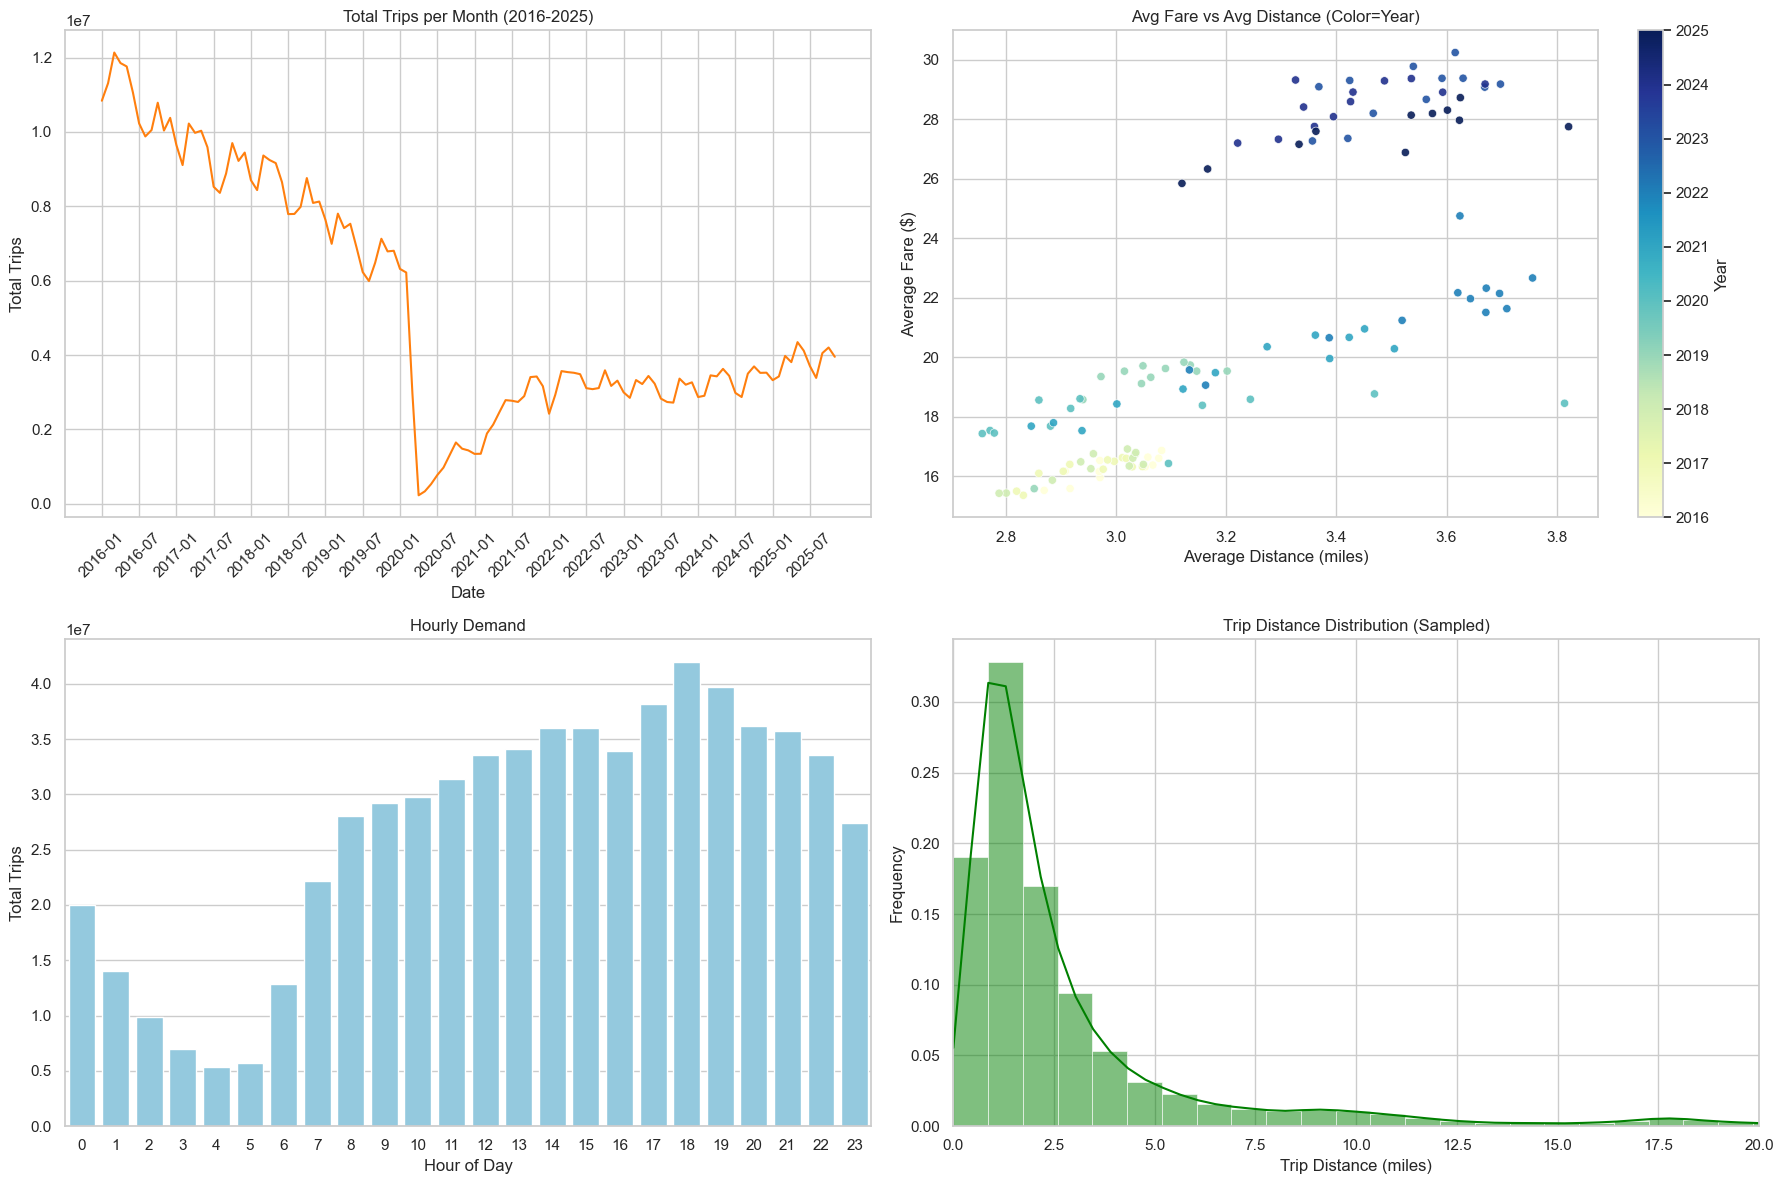

In [12]:
# 4. VISUALIZATION & OUTPUT
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Convert to Pandas
pdf_monthly = final_monthly.to_pandas()
pdf_hourly = final_hourly.to_pandas()

# Create 'date' column for plotting
pdf_monthly['date'] = pdf_monthly['year'].astype(str) + '-' + pdf_monthly['month'].astype(str).str.zfill(2)

# Plot 1: Monthly Trends
sns.lineplot(data=pdf_monthly, x='date', y='total_trips', ax=axes[0, 0], color='#ff7f0e')
axes[0, 0].set_title("Total Trips per Month (2016-2025)")
ticks = axes[0, 0].get_xticks()
axes[0, 0].set_xticks(ticks[::6]) # Reduce labels
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Total Trips")

# Plot 2: Economics
# Create a string version of year so Seaborn treats it as a category
pdf_monthly['year_cat'] = pdf_monthly['year'].astype(str)

# Sort so the legend is in order
pdf_monthly = pdf_monthly.sort_values('year')

# PLOT 2: Economics
norm = mpl.colors.Normalize(
    vmin=pdf_monthly['year'].min(),
    vmax=pdf_monthly['year'].max()
)

sns.scatterplot(
    data=pdf_monthly,
    x='avg_distance',
    y='avg_fare',
    hue='year',
    palette='YlGnBu',
    hue_norm=norm,
    alpha=0.9,
    ax=axes[0,1],
    legend=False   # turn off seaborn legend
)

# Add proper colorbar
sm = mpl.cm.ScalarMappable(cmap='YlGnBu', norm=norm)
sm.set_array([])
cbar = axes[0,1].figure.colorbar(sm, ax=axes[0,1])
cbar.set_label("Year")
axes[0, 1].set_title("Avg Fare vs Avg Distance (Color=Year)")
axes[0, 1].set_xlabel("Average Distance (miles)")
axes[0, 1].set_ylabel("Average Fare ($)")

# Plot 3: Hourly
sns.barplot(data=pdf_hourly, x='hour', y='total_trips', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title("Hourly Demand")
axes[1, 0].set_xlabel("Hour of Day")
axes[1, 0].set_ylabel("Total Trips")

# Plot 4: Distribution
if sample_df is not None and not sample_df.empty:
    sns.histplot(
        data=sample_df,
        x='trip_distance',
        bins=100,                 # smaller bins (was 25)
        kde=True,
        stat="count",             # keep raw counts
        weights=np.ones(len(sample_df)) / 100000,  # scale counts
        ax=axes[1, 1],
        color='green'
    )
    axes[1, 1].set_title("Trip Distance Distribution (Sampled)")
    axes[1, 1].set_xlim(0, 20)

axes[1, 1].set_xlabel("Trip Distance (miles)")
axes[1, 1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Save Data
pdf_monthly.to_csv("eda_data/nyc_taxi_monthly_summary.csv", index=False)
pdf_hourly.to_csv("eda_data/nyc_taxi_hourly_summary.csv", index=False)

In [ ]:
import polars as pl
import glob
import os
import shutil
import gc
import numpy as np

# ==========================================
# 1. SETUP
# ==========================================
DATA_FOLDER = "nyc_data"
TEMP_FOLDER = "temp_chunks"

# Clean/Create temp folder
if os.path.exists(TEMP_FOLDER):
    shutil.rmtree(TEMP_FOLDER)
os.makedirs(TEMP_FOLDER)

all_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "**/*.parquet")))
print(f"Found {len(all_files)} raw files.")

# ==========================================
# 2. PHASE 1: MAP (Process & Write to Disk)
# ==========================================
print(f"Starting Phase 1: Processing to {TEMP_FOLDER}...")

for i, file_path in enumerate(all_files):
    try:
        # 1. Scan without schema_overrides (Fix for older Polars)
        q = pl.scan_parquet(file_path)
        
        # 2. Handle Column Renaming (Normalization)
        cols = [c.lower() for c in q.columns]
        
        # Check if required columns exist (case-insensitive)
        if "tpep_pickup_datetime" in cols:
            time_col = "tpep_pickup_datetime"
        else:
            # Skip file if no timestamp
            continue
            
        # Find Location ID column
        loc_col = "PULocationID" if "pulocationid" in cols else None
        if not loc_col:
             # Try checking for case variants if needed, or skip
             continue

        # 3. Select, Cast, and Aggregate
        # We explicitly CAST inside the query to fix schema issues
        chunk_agg = (
            q
            .select([
                pl.col(time_col).alias("tpep_pickup_datetime"),
                pl.col(loc_col).alias("PULocationID")
            ])
            # Force types to match across all files
            .with_columns([
                pl.col("PULocationID").cast(pl.Int64),
                pl.col("tpep_pickup_datetime").cast(pl.Datetime)
            ])
            # Filter garbage
            .filter((pl.col("PULocationID") < 266) & (pl.col("PULocationID") > 0))
            # Truncate to Hour
            .with_columns(
                pl.col("tpep_pickup_datetime").dt.truncate("1h").alias("pickup_hour")
            )
            # Aggregate: Count trips per Hour per Location
            .group_by(["pickup_hour", "PULocationID"])
            .agg(pl.len().alias("demand"))
            .collect() # Materialize small chunk
        )
        
        # 4. Write to Disk (Saves RAM)
        if len(chunk_agg) > 0:
            output_name = os.path.join(TEMP_FOLDER, f"chunk_{i}.parquet")
            chunk_agg.write_parquet(output_name)
            print(f"[{i+1}/{len(all_files)}] Saved {output_name} ({len(chunk_agg)} rows)")
        
        # 5. Clear Memory
        del q, chunk_agg
        gc.collect()

    except Exception as e:
        print(f"Skipping file {i}: {e}")

In [ ]:
# ==========================================
# 3. PHASE 2: REDUCE (Merge Small Files)
# ==========================================
print("\nPhase 2: Merging processed chunks...")

# Scan the processed folder (LAZY mode)
q_final = pl.scan_parquet(os.path.join(TEMP_FOLDER, "*.parquet"))

# 1. Filter Date Outliers EARLY
# Adjust these years based on your actual dataset needs
VALID_START_YEAR = 2016
VALID_END_YEAR = 2025

q_final = q_final.filter(
    (pl.col("pickup_hour").dt.year() >= VALID_START_YEAR) & 
    (pl.col("pickup_hour").dt.year() <= VALID_END_YEAR)
)

# 2. Re-group and Collect History
# We collect here because we need the real min/max dates and top locations
# Since we filtered dates, this will be much smaller/safer.
df_history = (
    q_final
    .group_by(["pickup_hour", "PULocationID"])
    .agg(pl.col("demand").sum())
    .collect()
)

print(f"Total History Loaded: {len(df_history)} rows")

if len(df_history) == 0:
    print("Error: No data found after date filtering. Check VALID_START_YEAR/VALID_END_YEAR.")
    exit()

# ==========================================
# 4. PHASE 3: ZERO-FILLING & ML FEATURES
# ==========================================
print("Phase 3: Creating ML Features (Zero-Filling)...")

# 1. Select Top 50 Locations
top_locs_df = (
    df_history.group_by("PULocationID")
    .agg(pl.col("demand").sum())
    .sort("demand", descending=True)
    .head(50) 
    .select("PULocationID")
)

# 2. Create Time Grid (Safe now due to filtering)
min_date = df_history["pickup_hour"].min()
max_date = df_history["pickup_hour"].max()
print(f"Time range: {min_date} to {max_date}")

full_timeline = pl.datetime_range(min_date, max_date, interval="1h", eager=True).alias("pickup_hour").to_frame()

# 3. Create Grid (Lazy)
# Convert to lazy immediately to save RAM during the join
lz_timeline = full_timeline.lazy()
lz_locs = top_locs_df.lazy()

# Cross Join
lz_grid = lz_timeline.join(lz_locs, how="cross")

# 4. Join Data & Fill Nulls (Lazy)
lz_history = df_history.lazy()

lz_ml = (
    lz_grid
    .join(lz_history, on=["pickup_hour", "PULocationID"], how="left")
    .with_columns(pl.col("demand").fill_null(0))
    .sort(["PULocationID", "pickup_hour"])
)

# 5. Add Lag Features (Lazy)
print("Adding Lag Features definition...")
lz_features = (
    lz_ml
    .with_columns([
        # Time components
        pl.col("pickup_hour").dt.year().alias("year"),
        pl.col("pickup_hour").dt.month().alias("month"),
        pl.col("pickup_hour").dt.weekday().alias("day_of_week"),
        pl.col("pickup_hour").dt.hour().alias("hour"),
        
        # Historical Lags
        pl.col("demand").shift(1).over("PULocationID").alias("lag_1h"),
        pl.col("demand").shift(24).over("PULocationID").alias("lag_24h"),
        pl.col("demand").shift(168).over("PULocationID").alias("lag_7d"),
    ])
    .filter(pl.col("lag_7d").is_not_null()) # Remove first week of empty lags
)

# ==========================================
# 5. SAVE FINAL DATASET (STREAMING)
# ==========================================
output_file = "eda_data/nyc_taxi_demand_ml_ready.parquet"
print(f"Streaming result to {output_file}...")

# sink_parquet processes the data in batches, never holding the whole result in RAM.
lz_features.sink_parquet(output_file)

print("\n" + "="*40)
print(f"SUCCESS! ML Dataset saved to: {output_file}")
print("="*40)

# Optional: Cleanup
# shutil.rmtree(TEMP_FOLDER)


Phase 2: Merging processed chunks...
Total History Loaded: 10559078 rows
Phase 3: Creating ML Features (Zero-Filling)...
Time range: 2016-01-01 00:00:00 to 2025-11-30 23:00:00
Adding Lag Features definition...
Streaming result to eda_data/nyc_taxi_demand_ml_ready.parquet...

SUCCESS! ML Dataset saved to: eda_data/nyc_taxi_demand_ml_ready.parquet


In [ ]:
## gif net traffic over time (year/month/day) heatmap
## tip amount over location over a day heatmap

## equilibrium over three party (customer, taxi, government)

In [ ]:


# 1. Load your dataset (assuming a CSV format for this example)
# columns: ['LocationID', 'Time', 'Traffic_In', 'Traffic_Out']
df = pd.read_csv('your_traffic_data.csv')

# 2. Pre-process your data
# Ensure Time is in datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Calculate Net Traffic
df['Net_Traffic'] = df['Traffic_In'] - df['Traffic_Out']

# Convert Time to a format compatible with TimeSliderChoropleth (Unix timestamp)
# We calculate net traffic per zone per hour (or your specific time interval)
df['time_sec'] = df['Time'].astype(int) // 10**9 

# 3. Fetch GeoJSON via Open API (NYC Open Data - Taxi Zones)
# Socrata API Endpoint for NYC Taxi Zones (EPSG:4326 for lat/lon)


# The GeoJSON comes with a 'location_id' column. Ensure it matches your dataset's type.
gdf_zones['location_id'] = gdf_zones['location_id'].astype(int)

# Filter out zones that don't exist in your traffic data to keep the map clean
gdf_zones = gdf_zones[gdf_zones['location_id'].isin(df['LocationID'].unique())]

# 4. Create the Map
# Initialize map centered on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Prepare the style dictionary for TimeSliderChoropleth
# It requires a dictionary where keys are LocationIDs and values are distinct colors
# or a continuous color scale mapped to your data range.
# For simplicity, this example sets up the data structure required by the plugin.

# Create a styling function (maps net traffic values to colors)
# Note: Complex color scaling usually requires creating a specific color map (e.g., BrBG)
# Here we define the inputs for the plugin:
styledict = {}

for _, row in df.iterrows():
    loc_id = str(int(row['LocationID']))
    net_traffic = row['Net_Traffic']
    
    # Simple color logic: Red for negative (outflow), Green for positive (inflow)
    # In a real scenario, use matplotlib.cm to map values to hex codes accurately
    if net_traffic > 0:
        color = '#00ff00' # Green
        opacity = min(1.0, net_traffic / 100) # Normalize opacity based on max traffic
    else:
        color = '#ff0000' # Red
        opacity = min(1.0, abs(net_traffic) / 100)
        
    if loc_id not in styledict:
        styledict[loc_id] = {}
        
    # timestamp must be string in seconds
    styledict[loc_id][str(row['time_sec'])] = {
        'color': color,
        'opacity': opacity
    }

# 5. Add the Time Slider Layer
# Note: The geometry features in the GeoJSON must have an 'id' that matches the keys in styledict
# We assume the GeoJSON features have 'location_id' as their ID.
TimeSliderChoropleth(
    data=gdf_zones.to_json(),
    styledict=styledict
).add_to(m)

# 6. Save the map
m.save("nyc_net_traffic_heatmap.html")

NameError: name 'gpd' is not defined